In [1]:
# Import necessary libraries
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# neccessary tensorflow fuctions
datasets = tf.contrib.keras.datasets
layers =  tf.contrib.keras.layers
models = tf.contrib.keras.models
losses = tf.contrib.keras.losses
optimizers = tf.contrib.keras.optimizers 
metrics = tf.contrib.keras.metrics
preprocessing_image = tf.contrib.keras.preprocessing.image
utils = tf.contrib.keras.utils
callbacks = tf.contrib.keras.callbacks

In [3]:
# Load Cifar10 Dataset
(x_train, y_train),(x_test, y_test) = datasets.cifar10.load_data()

In [4]:
# Image Presprocessing and augmentation
train_datagen = preprocessing_image.ImageDataGenerator(
    rescale = 1./255,
    shear_range = 0.1, 
    zoom_range = 0.1,
    horizontal_flip= True)
test_datagen = preprocessing_image.ImageDataGenerator(rescale = 1./255)

In [5]:
# One  hot encoding of target vector
y_train = utils.to_categorical(y_train, num_classes=10)
y_test = utils.to_categorical(y_test, num_classes=10)

In [6]:
# Data Generator
train_generator = train_datagen.flow(x = x_train, y= y_train, batch_size=32, shuffle= True)

test_generator = test_datagen.flow(x= x_test, y= y_test, batch_size= 32, shuffle=True)

In [7]:
# Define fire model
def fire_module(x, fire_id, squeeze=16, expand=64):
    sq1x1 = "squeeze1x1"
    exp1x1 = "expand1x1"
    exp3x3 = "expand3x3"
    relu = "relu_"
    s_id = 'fire' + str(fire_id) + '/'

    # Squeeze layer
    x = layers.Convolution2D(squeeze, (1,1), padding='valid', name=s_id + sq1x1)(x)
    x = layers.Activation('relu', name=s_id + relu + sq1x1)(x)

    # Expand layer 1x1 filters
    left = layers.Convolution2D(expand, (1,1), padding='valid', name=s_id + exp1x1)(x)
    left = layers.Activation('relu', name=s_id + relu + exp1x1)(left)

    # Expand layer 3x3 filters
    right = layers.Convolution2D(expand, (3,3), padding='same', name=s_id + exp3x3)(x)
    right = layers.Activation('relu', name=s_id + relu + exp3x3)(right)

    # concatenate outputs
    x = layers.concatenate([left, right], axis=3, name=s_id + 'concat')

    
    return x

In [8]:
# Define Squeeze Net model
def SqueezeNet(input_shape=(32,32,3), classes=10):
    
    img_input = layers.Input(shape=input_shape)
    
    x = layers.Convolution2D(64, (3, 3), strides=(2, 2), padding='valid', name='conv1')(img_input)
    x = layers.Activation('relu', name='relu_conv1')(x)

    x = fire_module(x, fire_id=2, squeeze=16, expand=64)
    x = fire_module(x, fire_id=3, squeeze=16, expand=64)
    x = layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2), name='pool3')(x)

    x = fire_module(x, fire_id=4, squeeze=32, expand=128)
    x = fire_module(x, fire_id=5, squeeze=32, expand=128)
    x = layers.Dropout(0.5, name='drop9')(x)

    x = layers.Convolution2D(classes, (1, 1), padding='valid', name='conv10')(x)
    x = layers.Activation('relu', name='relu_conv10')(x)
    x = layers.GlobalAveragePooling2D()(x)
    out = layers.Activation('softmax', name='loss')(x)

    model = models.Model(img_input, out, name='squeezenet')

    return model

In [9]:
# Model summary
sn = SqueezeNet()
sn.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 15, 15, 64)   1792        input_1[0][0]                    
__________________________________________________________________________________________________
relu_conv1 (Activation)         (None, 15, 15, 64)   0           conv1[0][0]                      
__________________________________________________________________________________________________
fire2/squeeze1x1 (Conv2D)       (None, 15, 15, 16)   1040        relu_conv1[0][0]                 
__________________________________________________________________________________________________
fire2/relu

In [10]:
# Compile model
def compile_model(model):
    
    # loss
    loss = losses.categorical_crossentropy
    
    # optimizer
    optimizer = optimizers.RMSprop(lr=0.001)
    
    # metrics
    metric = [metrics.categorical_accuracy, metrics.top_k_categorical_accuracy]
    
    # Compile model with loss, optimizer, and evaluation metrics
    model.compile(optimizer, loss, metric)
    
    return model

In [11]:
# train model on cifar10

sn = compile_model(sn)

history = sn.fit_generator(
        train_generator,
        steps_per_epoch= 400,
        epochs = 10,
        validation_data = test_generator,
        validation_steps=200)

Epoch 1/10
400/400 [==============================] - 6s 14ms/step - loss: 2.2352 - categorical_accuracy: 0.1427 - top_k_categorical_accuracy: 0.7472 - val_loss: 2.1285 - val_categorical_accuracy: 0.1988 - val_top_k_categorical_accuracy: 0.7473
Epoch 2/10
400/400 [==============================] - 4s 9ms/step - loss: 1.9652 - categorical_accuracy: 0.2620 - top_k_categorical_accuracy: 0.8009 - val_loss: 2.1548 - val_categorical_accuracy: 0.2128 - val_top_k_categorical_accuracy: 0.7292
Epoch 3/10
400/400 [==============================] - 4s 9ms/step - loss: 1.8252 - categorical_accuracy: 0.3216 - top_k_categorical_accuracy: 0.8438 - val_loss: 1.6839 - val_categorical_accuracy: 0.3831 - val_top_k_categorical_accuracy: 0.8798
Epoch 4/10
400/400 [==============================] - 4s 9ms/step - loss: 1.7079 - categorical_accuracy: 0.3670 - top_k_categorical_accuracy: 0.8763 - val_loss: 1.5847 - val_categorical_accuracy: 0.4217 - val_top_k_categorical_accuracy: 0.8955
Epoch 5/10
400/400 [===

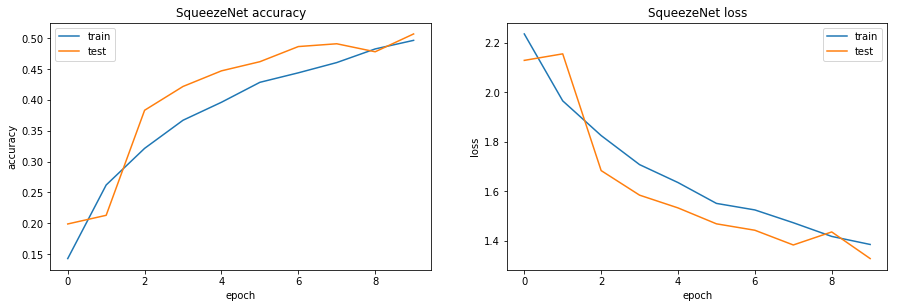

In [12]:
# Plot data
def plot_accuracy_and_loss(history):
    plt.figure(1, figsize= (15, 10))
    
    # plot train and test accuracy
    plt.subplot(221)
    plt.plot(history.history['categorical_accuracy'])
    plt.plot(history.history['val_categorical_accuracy'])
    plt.title('SqueezeNet accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')

    # plot train and test loss
    plt.subplot(222)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('SqueezeNet loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper right')
    
    plt.savefig("Squeeze Net.jpg")
    plt.show()

plot_accuracy_and_loss(history)

In [13]:
# save model architecture
model_json = sn.to_json()
open('squeeze_net_model.json', 'w').write(model_json)

# save model's learned weights
sn.save_weights('image_classifier_squeeze_net.h5', overwrite=True)